In [3]:
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # life saving


path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


In [7]:
labels_dict # dictionary used to encode emotions

{'Disgusted': 0,
 'Fearful': 1,
 'Neutral': 2,
 'Happy': 3,
 'Angry': 4,
 'Sad': 5,
 'Suprised': 6}

In [6]:
eval_df

,filename
0,9597.wav
1,9598.wav
2,9599.wav
3,9600.wav
4,9601.wav
...,...
3196,12793.wav
3197,12794.wav
3198,12795.wav
3199,12796.wav


In [8]:
emotion_sr = df.emotion.value_counts()
emotion_sr.index
print('label\tnumber of samples')
emotion_sr

label	number of samples


Happy        1625
Angry        1625
Sad          1625
Fearful      1535
Disgusted    1397
Neutral      1346
Suprised      444
Name: emotion, dtype: Int64

In [25]:
# define the color palette
colors = ['kelly green',     # Disgusted
          'medium purple',    # Fearful
          'grey',             # Neutral
          'lemon yellow',     # Happy
          'vermillion',       # Angry
          'cerulean blue',    # Sad
          'powder blue']      # Surprised
     
my_palette = sns.xkcd_palette(colors)

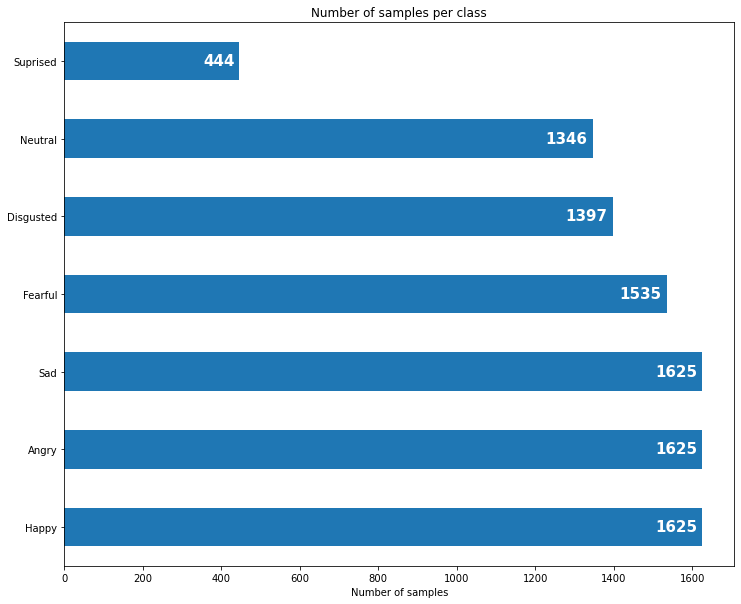

In [11]:
emotion_val_series = df.emotion.value_counts()
emotion_val_series.plot(kind='barh', figsize=(12,10), color='tab:blue')
for i, v in enumerate(emotion_val_series):
    if i == len(emotion_val_series)-1:
        plt.text(v - 90, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)
    else:
        plt.text(v - 120, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)
plt.title('Number of samples per class')
plt.xlabel('Number of samples')
plt.show()

We use librosa to process audio data. When we load an audio file, it's amplitude is normalized. 
To see what is the range of sampling data, we exploited `scipy.io.wavfile`. We see that the sampling rate is 8 kHz and the format is 16-bit.

|WAV format        |Min   |Max   |NumPy dtype|
|------------------|------|------|-----------|
|16-bit integer PCM|-32768|+32767|int16      |

We have 7 different class labels for a total of 9597 training samples (out of 12798 of the overall dataset):
- Surprised (444)
- Neutral   (1346)
- Disgusted (1397)
- Fearful   (1535)
- Sad       (1625)
- Angry     (1625)
- Happy     (1625)

Most of them are balanced but "Surprised" has way less samples. Hence, we need to deal with it.

# Data visualization

In [17]:
filenames = list(df.filename)
audio_file = audio_path+filenames[0]
signal, sr = librosa.load(audio_file, sr=None)

Text(0.5, 1.0, 'Waveform')

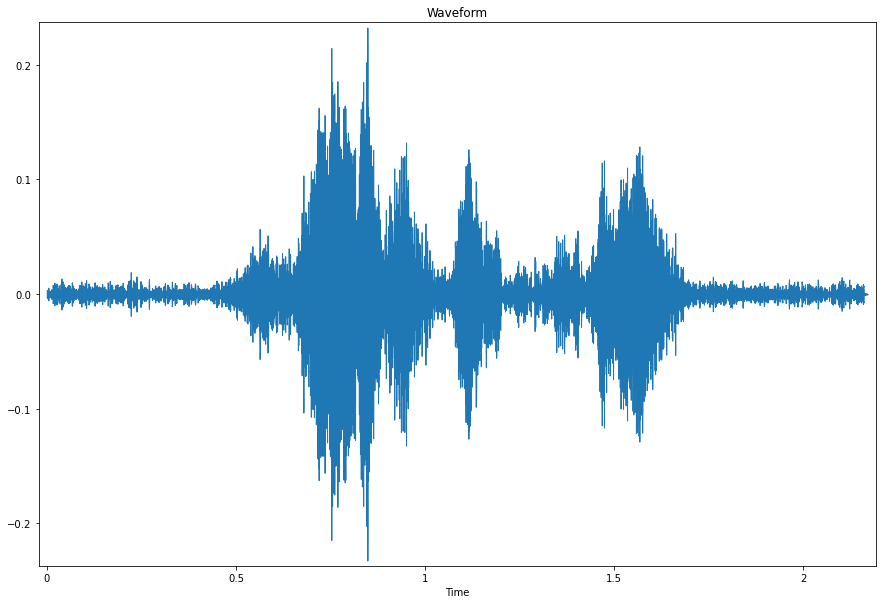

In [22]:
plt.figure(figsize=(15,10))
librosa.display.waveshow(signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title('Waveform')

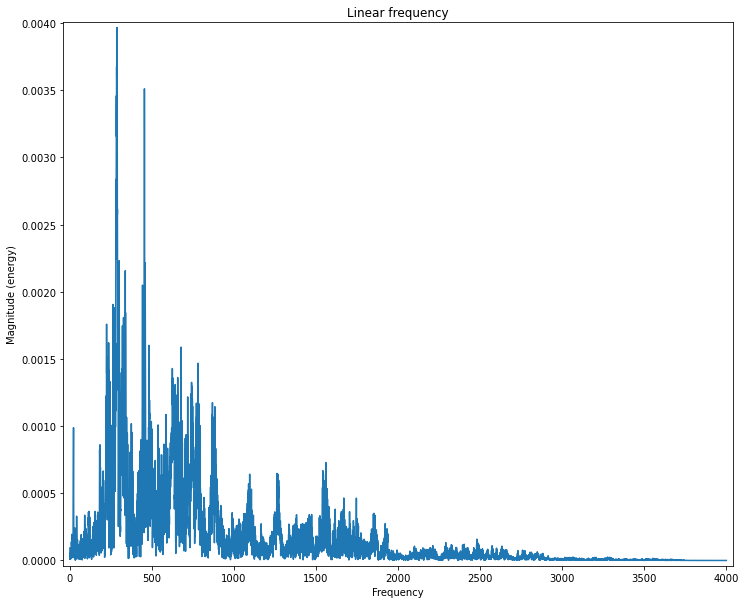

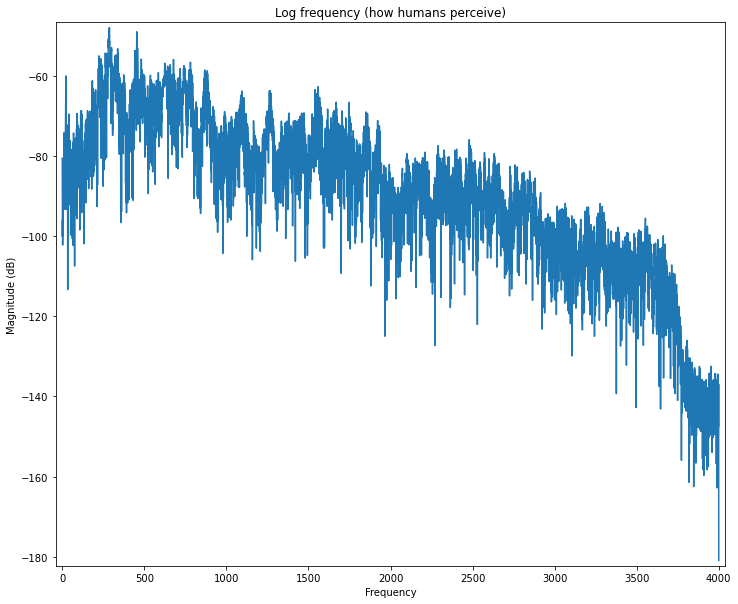

In [25]:
plt.figure(figsize=(12,10))
plt.magnitude_spectrum(signal, sr, scale='linear')
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title('Linear frequency')
plt.show()

plt.figure(figsize=(12,10))
plt.magnitude_spectrum(signal, sr, scale='dB')
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title('Log frequency (how humans perceive)')
plt.show()

--------------
### Noise reduction and trimming heading and trailing silences

In [4]:
import noisereduce as nr

def denoise(signal, sr):
    return nr.reduce_noise(signal, sr)

def trim_silence(signal, top_db=30):
    trimmed_signal, index = librosa.effects.trim(signal, top_db=top_db)
    return trimmed_signal

def denoise_and_trim(signal, sr, top_db=30):
    denoised_signal = denoise(signal, sr)
    return trim_silence(denoised_signal, top_db)

In [6]:
silence_files = []

for filename in tqdm(df.filename):
    signal, sr = librosa.load(audio_path+filename, sr=None)
    processed_signal = denoise_and_trim(signal, sr, top_db=30)
    
    # check if the signal is empty (hence it contains just silence)
    if processed_signal.size == 0:
        silence_files.append(filename)
        print(filename)
        continue

 83%|████████▎ | 8002/9597 [03:23<00:40, 39.38it/s]/Users/lorenzo/opt/anaconda3/envs/data_science/lib/python3.10/site-packages/noisereduce/noisereduce.py:306: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
 83%|████████▎ | 8011/9597 [03:24<00:40, 39.20it/s]

8005.wav


100%|██████████| 9597/9597 [04:03<00:00, 39.36it/s]


We have processed all the signals by applying noise reduction and audio trimming. By running some experiments, top_db set to 30 seems a good choice.

Let's visualize the comparison between the original version and the denoised one.

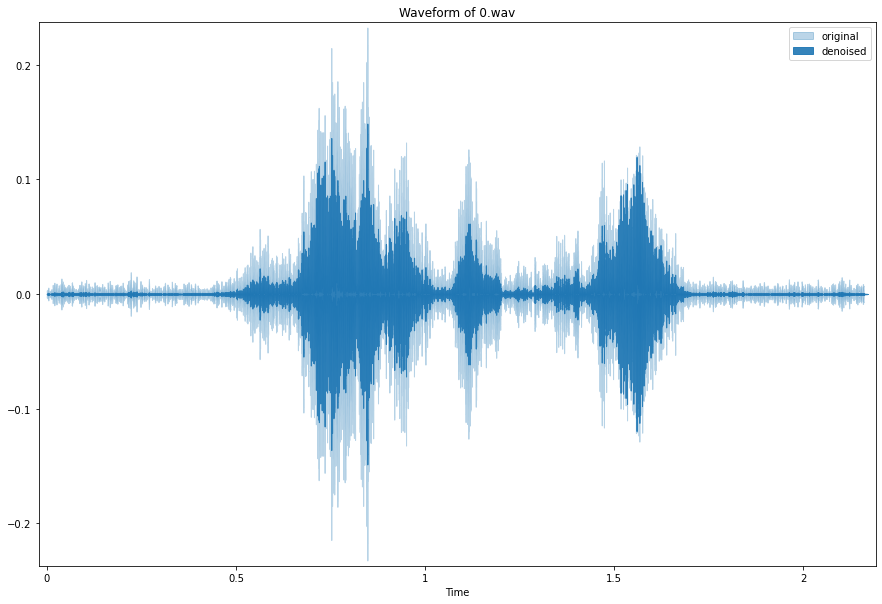

In [16]:
audio_file = audio_path+df.filename[0]
signal, sr = librosa.load(audio_file, sr=None, mono=True)
plt.figure(figsize=(15,10))
plt.title(f'Waveform of {df.filename[0]}')
librosa.display.waveshow(signal, sr, label='original', alpha=.3)#, ax=ax[i])
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters

reduced_signal = nr.reduce_noise(signal, sr)
librosa.display.waveshow(reduced_signal, sr, label='denoised', alpha=.9, color='tab:blue')#, ax=ax[i])
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.legend()
plt.show()

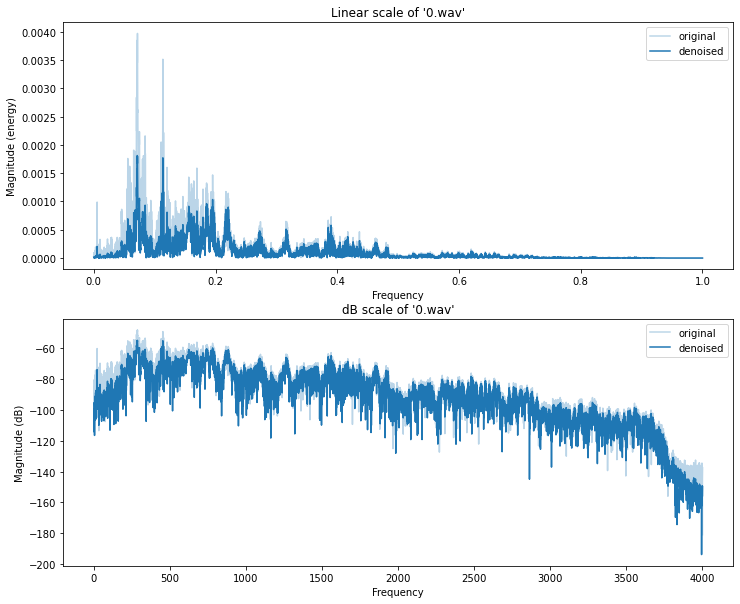

In [18]:
# differences in frequency domain

# set figure dimension
plt.figure(figsize=(12,10))

# plot linear energy over frequency 
plt.subplot(2,1,1)
plt.title(f"Linear scale of '{df.filename[0]}'")
plt.magnitude_spectrum(signal, scale='linear', alpha=.3, label='original')
plt.magnitude_spectrum(reduced_signal, scale='linear', label='denoised', color='tab:blue')
plt.margins(x=0.05, y=0.05) # set to 1% to margin parameters

plt.legend()

# plot log energy over frequency (as human perceive)
plt.subplot(2,1,2)
plt.title(f"dB scale of '{df.filename[0]}'")
plt.magnitude_spectrum(signal, sr, scale='dB', alpha=.3, label='original')
plt.magnitude_spectrum(reduced_signal, sr, scale='dB', label='denoised', color='tab:blue')
plt.margins(x=0.05, y=0.05) # set to 1% to margin parameters

plt.legend()

We have seen the denoise part. Now we visualize the trimmed one

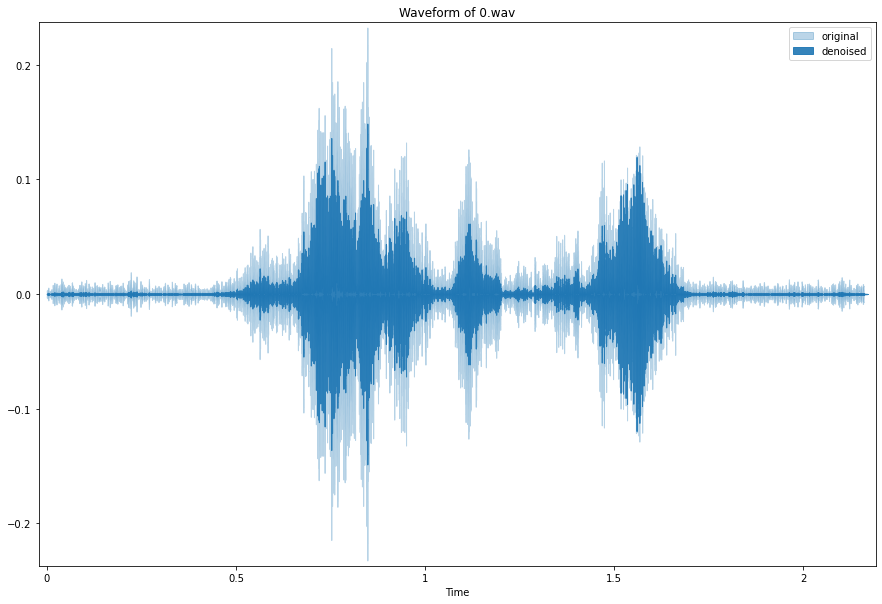

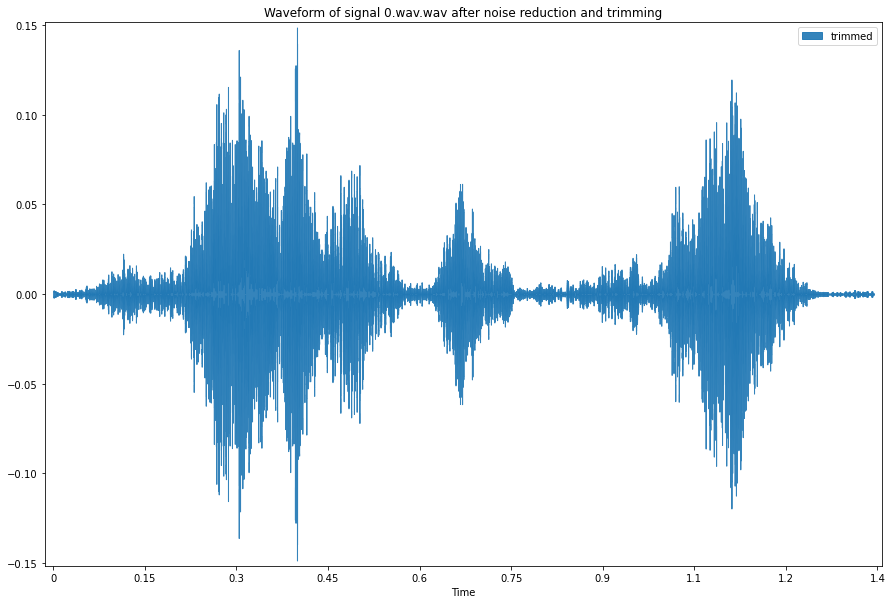

In [22]:
audio_file = audio_path+df.filename[0]
signal, sr = librosa.load(audio_file, sr=None, mono=True)
plt.figure(figsize=(15,10))
plt.title(f'Waveform of {df.filename[0]}')
librosa.display.waveshow(signal, sr, label='original', alpha=.3)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters

reduced_signal = nr.reduce_noise(signal, sr)
librosa.display.waveshow(reduced_signal, sr, label='denoised', alpha=.9, color='tab:blue')
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
trimmed_signal = trim_silence(reduced_signal, top_db = 30)
librosa.display.waveshow(trimmed_signal, sr, label='trimmed', alpha=.9, color='tab:blue')
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f'Waveform of signal {df.filename[0]}.wav after noise reduction and trimming')
plt.legend()
plt.show()

During the processing of trimming, we have encountered a silent vocal. We remove it.

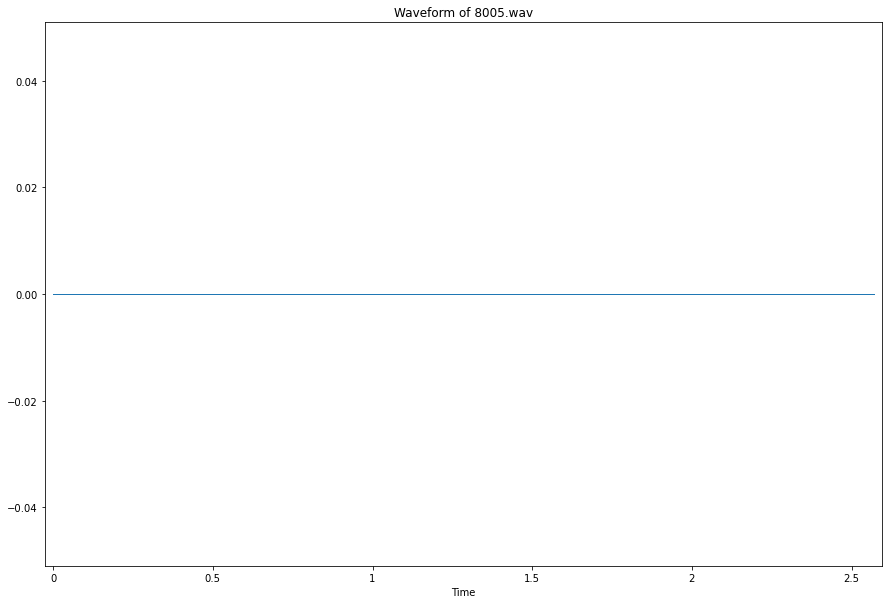

In [13]:
# transform silence files to the corresponding index
rows_to_remove = [(int)(file.split('.')[0]) for file in silence_files]
 
for row in rows_to_remove:
    audio_file = audio_path+f'{row}.wav'
    signal, sr = librosa.load(audio_file, sr=None)
    plt.figure(figsize=(15,10))
    
    librosa.display.waveshow(signal, sr)
    plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
    plt.title(f'Waveform of {row}.wav')
    
    plt.show()

In [12]:
df.drop(index=rows_to_remove, inplace=True)
df

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4
...,...,...,...
9592,Happy,9592.wav,3
9593,Happy,9593.wav,3
9594,Sad,9594.wav,5
9595,Happy,9595.wav,3


Data concerning row 8005 were discarded. It was a _sad_ instance.

Unfortunately, results conducted on such processed signals were lower than the ones without this kind of preprocessing. Maybe we removed some feature of the signal that shouldn't be removed. Albeit this, we believe that the noise removal was and subsequently silence trimming is the right route to follow. 

A further investigation on threshold db and how noise reduction should be done to confirm that. 

Due time constraints, such investigations were not done. Hence, we proceed without this kind of preprocessing.

_Note_: we still remove silent instances.

---------------

# Data preprocessing

Recordings show lot of noise (even if we don't hear recordings one by one we can recognize it).

We tried some denoising approach but results were lower than the ones in which we didn't use it. Hence, here we will continue without applying denoising.

Features that we use are:
- 40 MFCCs coefficients (mean and std)
- 1st and 2nd order delta of those MFCCs coefficients (just the mean)
- chroma (mean of each pitch class)
  - argmin and argmax of chroma. To see which pitch class has the minimum and maximum value
- duration
- zero crossing rate (rate at which a signal cross the zero amplitude)
- rms (it is an indicator of loudness)

### Build the dataframes with extracted features

In [23]:
# development
d = dict()
# all the files have been sampled using the same sample rate. Hence we extract it
sr, _ = wavfile.read(audio_path + df.filename.iloc[0])
for filename in tqdm(df.filename):
    d1 = dict()
    
    signal, _ = librosa.load(audio_path+filename, sr=None)
  
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
    mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
    res = np.hstack((mfccs_mean, mfccs_std))
    
    delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
    res = np.hstack((res, delta_mfccs_mean))
    
    delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
    res = np.hstack((res, delta2_mfccs_mean))
    
    stft = np.abs(librosa.stft(signal))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
    res = np.hstack((res, chroma_stft))
    
    chroma_argmin = np.argmin(chroma_stft)
    res = np.hstack((res, chroma_stft))
    
    chroma_argmax = np.argmax(chroma_stft)
    res = np.hstack((res, chroma_stft))
    
    
    
    d1 = {f'feature_{k}':v for k,v in enumerate(res)} # extract mfccs
    
    d1['duration'] = signal.shape[0]/sr
    d1['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
    d1['rms'] = np.mean(librosa.feature.rms(y=signal), axis=-1)[0]

    d[(int)(filename.split('.')[0])] = d1
    
temp_df = pd.DataFrame.from_dict(d).T    
temp_df['emotion'] = df.emotion
temp_df['encoded_emotion'] = df.encoded_emotion
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9596/9596 [03:32<00:00, 45.13it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_191,feature_192,feature_193,feature_194,feature_195,duration,zcr,rms,emotion,encoded_emotion
0,-317.810974,130.704483,-12.395517,30.511158,-20.439678,3.617439,-10.423512,7.929957,-14.021802,-2.930775,...,0.661096,0.632921,0.774900,0.737488,0.563047,2.169000,0.101017,0.022118,Disgusted,0
1,-396.103882,144.796555,18.632975,41.450970,-8.002732,10.079015,-11.788765,6.078516,-8.807680,-0.646100,...,0.520044,0.722071,0.826758,0.766087,0.470141,2.669500,0.067057,0.011704,Fearful,1
2,-556.759644,61.434036,-2.091408,13.791684,-8.940442,-2.057548,-14.456757,4.195601,-8.435582,5.987458,...,0.710356,0.702440,0.702173,0.701752,0.685739,3.837375,0.081445,0.006343,Neutral,2
3,-570.338440,53.714615,-5.728349,19.494200,-12.612115,1.432346,-10.988893,8.573183,-2.576330,6.206134,...,0.664319,0.652212,0.693982,0.707066,0.807382,3.403625,0.094916,0.005601,Happy,3
4,-167.229965,97.665352,-14.925374,16.654722,-36.905621,4.324324,-21.103331,-0.462943,-10.539716,-1.436900,...,0.571357,0.526096,0.596822,0.739495,0.727407,2.869750,0.123644,0.160394,Angry,4


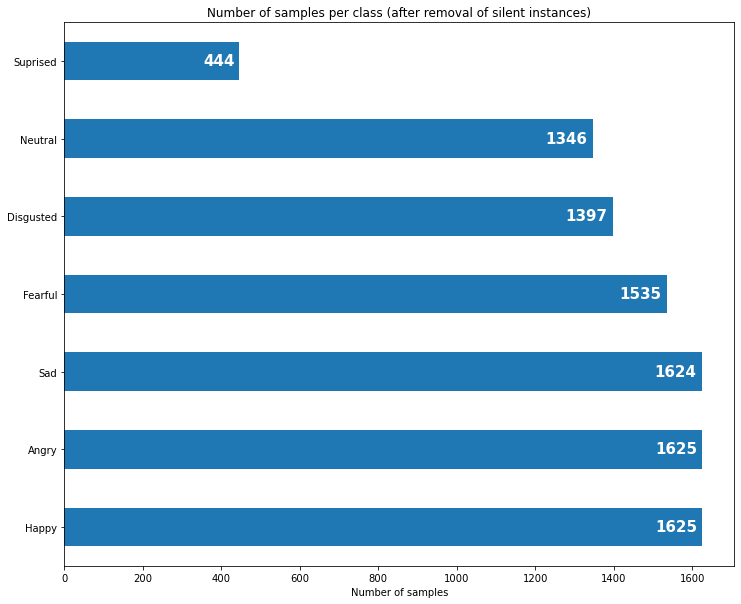

In [28]:
emotion_val_series = df.emotion.value_counts()
emotion_val_series.plot(kind='barh', figsize=(12,10), color='tab:blue')
for i, v in enumerate(emotion_val_series):
    if i == len(emotion_val_series)-1:
        plt.text(v - 90, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)
    else:
        plt.text(v - 120, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)
plt.title('Number of samples per class (after removal of silent instances)')
plt.xlabel('Number of samples')
plt.savefig('./figures/num_samples_per_class_8005_removed.svg', format='svg')
plt.show()

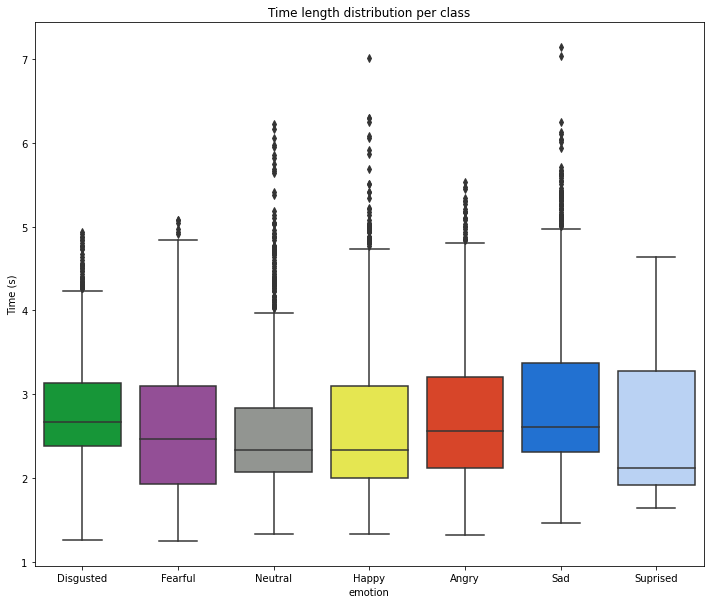

In [29]:
plt.figure(figsize=(12,10))
sns.boxplot(x='emotion', y='duration', data=temp_df, palette=my_palette)
plt.title('Time length distribution per class')
plt.ylabel('Time (s)')
plt.savefig('./figures/boxplot.svg', format='svg')
plt.show()

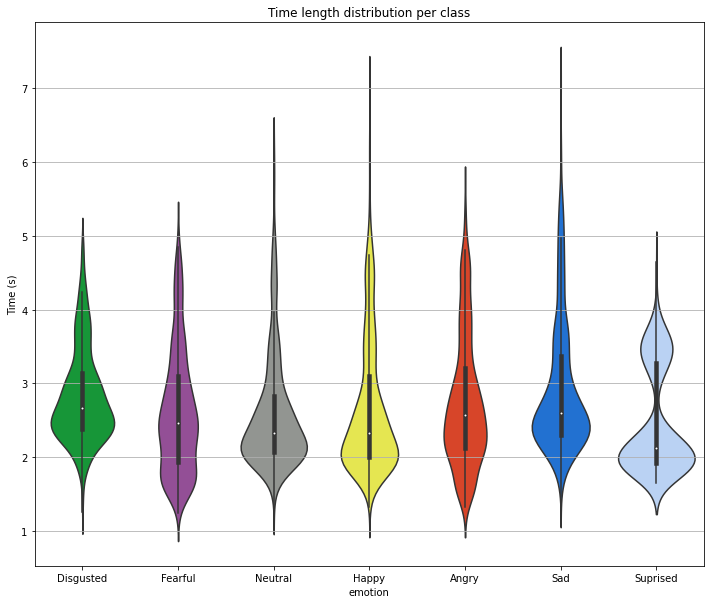

In [30]:
plt.figure(figsize=(12,10))
sns.violinplot(x='emotion', y='duration', data=temp_df, palette=my_palette)
plt.title('Time length distribution per class')
plt.grid(axis='y')
plt.ylabel('Time (s)')
plt.savefig('./figures/violinplot.svg', format='svg')
plt.show()

From box-plot and violin-plot we can see that all classes have half of their samples (time concerning) that is more concentrated while the other half is more spred.

In [31]:
temp_df.groupby('emotion')['duration'].describe()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
emotion,,,,
Angry,2.758348,0.889712,1.326625,5.527875
Disgusted,2.830282,0.638181,1.268000,4.938500
Fearful,2.615037,0.833615,1.254125,5.071750
Happy,2.669564,0.906174,1.334750,7.012625
Neutral,2.602233,0.785585,1.334750,6.226500
Sad,2.941485,0.900870,1.468250,7.138750
Suprised,2.468897,0.704724,1.650125,4.638125


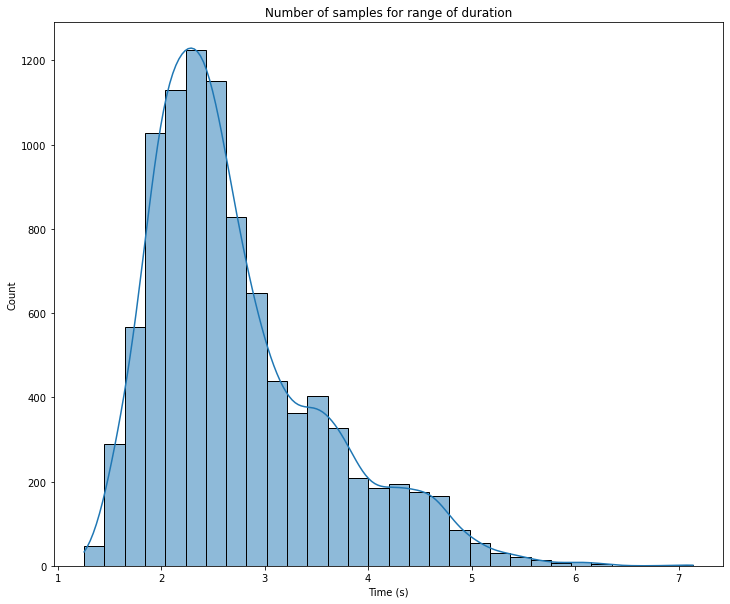

In [33]:
plt.figure(figsize=(12,10))
sns.histplot(temp_df.duration, bins=30, kde=True, color='tab:blue')
plt.title('Number of samples for range of duration')
plt.xlabel('Time (s)')
plt.savefig('./figures/time_duration.svg', format='svg')
plt.show()

Even here we see the behaviour recognized before.

There are very few samples that are very long. They could contain silences. Let's inspect such samples.

In [34]:
mask = temp_df.duration > 6
temp_df[mask][['duration','emotion']]

,duration,emotion
434,6.039500,Sad
494,6.242250,Happy
1921,6.032750,Sad
1985,6.129625,Sad
2039,6.289375,Happy
2391,6.058750,Happy
2669,6.156625,Neutral
2751,6.289375,Happy
3824,6.226500,Neutral
4672,7.012625,Happy


By manual inspection, they don't have silences.

In [48]:
for i in range(5,8):
    print(f'{i} seconds threshold')
    mask = temp_df.duration > i
    print(temp_df[mask].emotion.value_counts())

5 seconds threshold
Sad        74
Happy      27
Neutral    21
Angry      17
Fearful     3
Name: emotion, dtype: Int64
6 seconds threshold
Sad        8
Happy      6
Neutral    3
Name: emotion, dtype: Int64
7 seconds threshold
Sad      2
Happy    1
Name: emotion, dtype: Int64


Classes with longest samples are _sad_ and _happy_.

We now show the time length distribution for each class. (If you check the violin-plot, it's the same!)

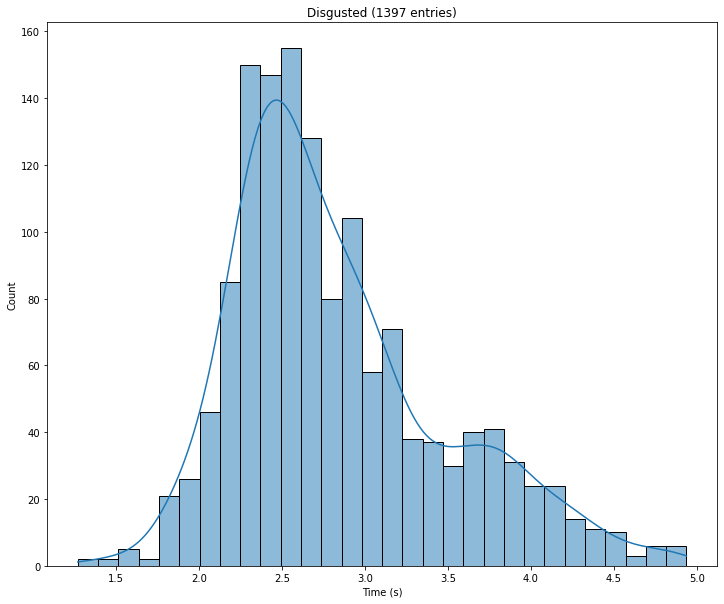

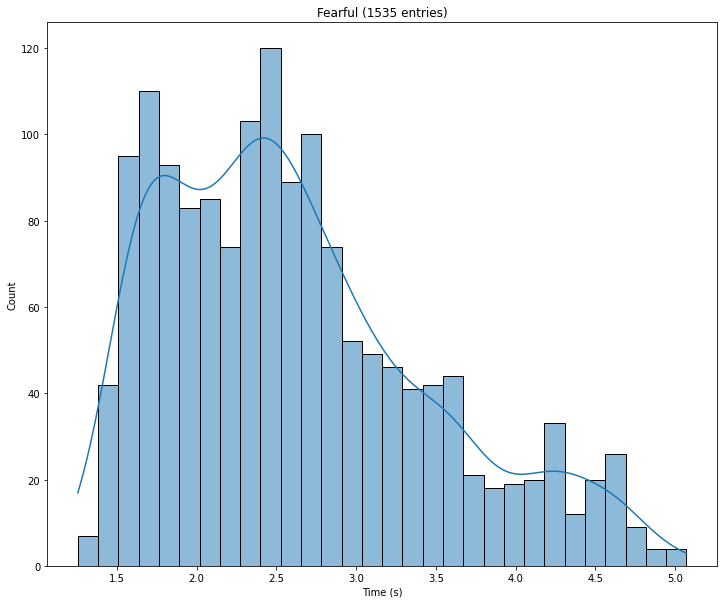

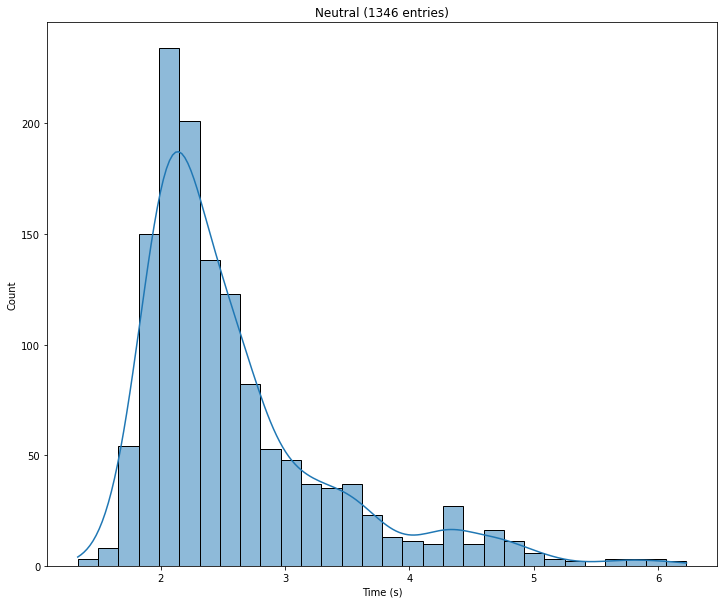

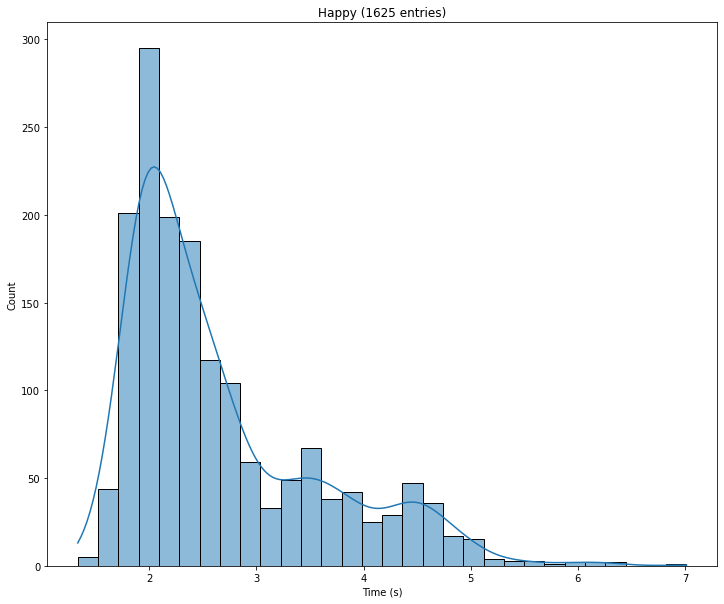

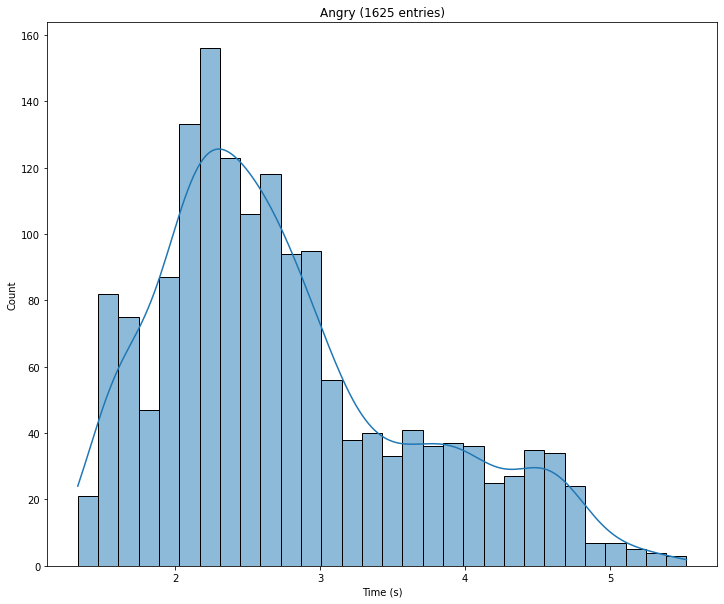

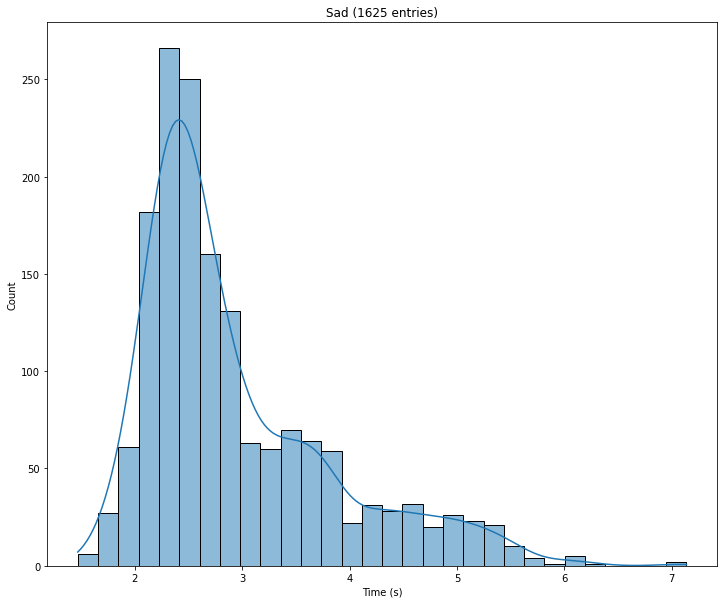

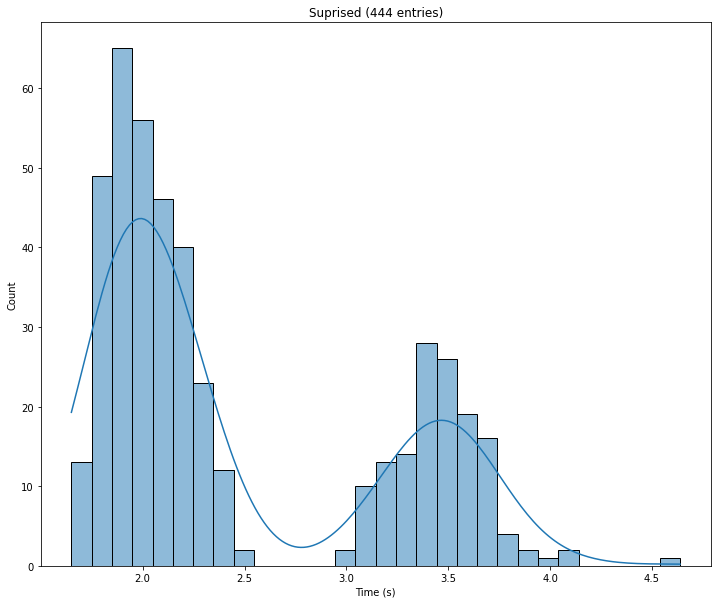

In [54]:
for i in range(len(labels)):
    plt.figure(figsize=(12,10))
    mask = temp_df.emotion == labels[i]
    sns.histplot(temp_df[mask].duration, bins=30, color='tab:blue', kde=True)
    plt.title(labels[i] + f' ({len(temp_df[mask])} entries)')
    plt.xlabel('Time (s)')
    plt.show()

In [35]:
# eval

d = dict()
for filename in tqdm(eval_df.filename):
    d1 = dict()
    features = []
    signal, _ = librosa.load(audio_path+filename, sr=None, res_type='kaiser_fast')

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
    mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
    res = np.hstack((mfccs_mean, mfccs_std))
    
    delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
    res = np.hstack((res, delta_mfccs_mean))
    
    delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
    res = np.hstack((res, delta2_mfccs_mean))
    
    stft = np.abs(librosa.stft(signal))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
    res = np.hstack((res, chroma_stft))
    
    chroma_argmin = np.argmin(chroma_stft)
    res = np.hstack((res, chroma_stft))
    
    chroma_argmax = np.argmax(chroma_stft)
    res = np.hstack((res, chroma_stft))
    
    
    
    d1 = {f'feature_{k}':v for k,v in enumerate(res)} # extract mfccs
    
    d1['duration'] = signal.shape[0]/sr
    d1['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
    d1['rms'] = np.mean(librosa.feature.rms(y=signal), axis=-1)[0]

    d[(int)(filename.split('.')[0])] = d1
    
eval_temp_df = pd.DataFrame.from_dict(d).T    

eval_temp_df = eval_temp_df.astype({'duration':float})
eval_temp_df.head()
indexes = eval_temp_df.index

100%|██████████| 3201/3201 [00:56<00:00, 56.54it/s]


In [36]:
eval_silence_files = []

for filename in tqdm(eval_df.filename):
    signal, sr = librosa.load(audio_path+filename, sr=None)
    processed_signal = denoise_and_trim(signal, sr, top_db=30)
    
    # check if the signal is empty (hence it contains just silence)
    if processed_signal.size == 0:
        silence_files.append(filename)
        print(filename)
        continue
    
# transform silence files to the corresponding index
rows_to_remove = [(int)(file.split('.')[0]) for file in eval_silence_files]

if len(rows_to_remove) != 0:
    eval_df.drop(index=rows_to_remove, inplace=True)

eval_df

100%|██████████| 3201/3201 [01:17<00:00, 41.46it/s]


,filename
0,9597.wav
1,9598.wav
2,9599.wav
3,9600.wav
4,9601.wav
...,...
3196,12793.wav
3197,12794.wav
3198,12795.wav
3199,12796.wav


# Oversampling

In [37]:
# remove the useless column concerning emotion. We have the encoded one
temp_df.drop(['emotion'], axis='columns', inplace=True)

To deal with the low quantity of 'surprised' sample, we now exploit SMOTE to oversample the minority class.
SMOTE is an algorithm that has the aim to oversample imbalanced classes. SMOTE selects an instance of the imbalanced class, choose one of its k nearest neighbors and create a synthetic instance made of the convex combination of the 2 instances.

In such a manner, it is more general than just count twice or more one instance of the low-quantity class.

In [38]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

np.random.seed(0) 

smote = SMOTE(random_state=42)

X, y = temp_df[temp_df.columns[:-1]], temp_df[temp_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

# Build the model

Since we have many features, we apply PCA to retain the most important ones.

We choose to use 2 + 1 different classifiers:
- Random Forest
- Support Vector Machines
- a voting classifier that uses Random Forest and SVM

The number of components to choose for PCA is chosen between 10 and the half of the current number of features. Here we use plain models, then we will finetune them.

In [43]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [46]:
def run_cross_val(X_train_valid, y_train_valid, n_kf:int=3):
    
    kf = KFold(n_kf)
    
    scores_rf = []
    scores_svm = []
    scores_vc = []

    counts = []
    for train_indices, valid_indices in tqdm(kf.split(X_train_valid)):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid.iloc[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid.iloc[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 

        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        rf_score = f1_score(y_valid, rf.predict(X_valid), average='macro')
        # print('RF:',rf_score)
        scores_rf.append(rf_score)
        
        svc = SVC(probability=True, random_state=42)
        svc.fit(X_train, y_train)
        svc_score = f1_score(y_valid, svc.predict(X_valid), average='macro')
        # print('SVM:',svc_score)
        scores_svm.append(svc_score)
        
        vc = VotingClassifier([('svm',svc), ('rf', rf)], voting='soft').fit(X_train, y_train)
        vc_score = f1_score(y_valid, vc.predict(X_valid), average='macro')
        # print('VC:',vc_score)
        scores_vc.append(vc_score)
        
    rf_avg = np.average(scores_rf, weights=counts)
    svm_avg = np.average(scores_svm, weights=counts)
    vc_avg = np.average(scores_vc, weights=counts)
        
    # print('RF average F1:',rf_avg)
    # print('SVM average F1:', svm_avg)
    # print('VC average F1:', vc_avg)

    return rf_avg, svm_avg, vc_avg

  0%|          | 0/18 [00:00<?, ?it/s]

10


10it [04:28, 26.84s/it]
  6%|▌         | 1/18 [04:28<1:16:06, 268.59s/it]

RF: 0.6424
SVM: 0.6161
VC: 0.6429
15


10it [04:55, 29.58s/it]
 11%|█         | 2/18 [09:24<1:15:54, 284.68s/it]

RF: 0.6744
SVM: 0.6631
VC: 0.6837
20


10it [05:01, 30.14s/it]
 17%|█▋        | 3/18 [14:26<1:13:05, 292.37s/it]

RF: 0.6814
SVM: 0.6833
VC: 0.6969
25


10it [05:38, 33.82s/it]
 22%|██▏       | 4/18 [20:04<1:12:27, 310.53s/it]

RF: 0.6850
SVM: 0.6914
VC: 0.7083
30


10it [06:10, 37.03s/it]
 28%|██▊       | 5/18 [26:14<1:11:57, 332.15s/it]

RF: 0.6869
SVM: 0.7026
VC: 0.7189
35


10it [06:42, 40.29s/it]
 33%|███▎      | 6/18 [32:57<1:11:14, 356.24s/it]

RF: 0.6929
SVM: 0.7126
VC: 0.7230
40


10it [07:32, 45.29s/it]
 39%|███▉      | 7/18 [40:30<1:11:06, 387.88s/it]

RF: 0.6945
SVM: 0.7147
VC: 0.7261
45


10it [07:55, 47.58s/it]
 44%|████▍     | 8/18 [48:26<1:09:19, 415.93s/it]

RF: 0.6890
SVM: 0.7166
VC: 0.7244
50


10it [07:44, 46.44s/it]
 50%|█████     | 9/18 [56:11<1:04:40, 431.15s/it]

RF: 0.6877
SVM: 0.7213
VC: 0.7274
55


10it [08:33, 51.38s/it]
 56%|█████▌    | 10/18 [1:04:45<1:00:53, 456.74s/it]

RF: 0.6879
SVM: 0.7195
VC: 0.7262
60


10it [09:34, 57.44s/it]
 61%|██████    | 11/18 [1:14:20<57:29, 492.81s/it]  

RF: 0.6865
SVM: 0.7197
VC: 0.7253
65


10it [09:32, 57.29s/it]
 67%|██████▋   | 12/18 [1:23:53<51:43, 517.25s/it]

RF: 0.6836
SVM: 0.7209
VC: 0.7257
70


10it [10:02, 60.24s/it]
 72%|███████▏  | 13/18 [1:33:55<45:15, 543.11s/it]

RF: 0.6846
SVM: 0.7195
VC: 0.7285
75


10it [10:29, 62.95s/it]
 78%|███████▊  | 14/18 [1:44:25<37:57, 569.28s/it]

RF: 0.6826
SVM: 0.7197
VC: 0.7264
80


10it [09:01, 54.18s/it]
 83%|████████▎ | 15/18 [1:53:27<28:03, 561.06s/it]

RF: 0.6790
SVM: 0.7162
VC: 0.7229
85


10it [10:36, 63.69s/it]
 89%|████████▉ | 16/18 [2:04:04<19:27, 583.96s/it]

RF: 0.6826
SVM: 0.7121
VC: 0.7217
90


10it [11:32, 69.27s/it]
 94%|█████████▍| 17/18 [2:15:37<10:16, 616.76s/it]

RF: 0.6888
SVM: 0.7221
VC: 0.7274
95


10it [12:10, 73.08s/it]
100%|██████████| 18/18 [2:27:49<00:00, 492.72s/it]

RF: 0.6874
SVM: 0.7193
VC: 0.7276


Text(0.5, 1.0, 'F1 macro score as number of PCA components varies')

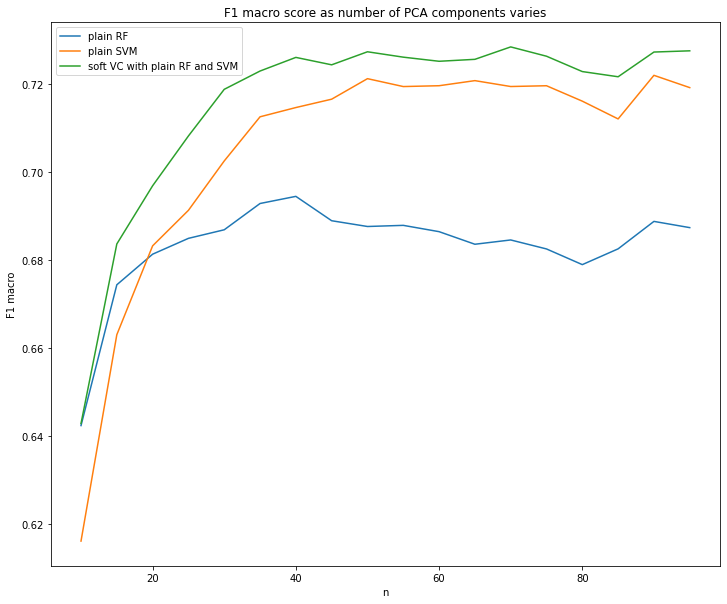

In [74]:
# PCA tuning

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# ----- PCA ----- #
from sklearn.decomposition import PCA

ns = list(range(10, round(len(X.columns)/2),5))
scores_rf = []
scores_svm = [] 
scores_vc = []
for n in tqdm(ns):
    print(n)
    pca = PCA(n_components=n, random_state=42)
    pca_X = pca.fit_transform(X_res)

    # Standardization
    minmax = MinMaxScaler()
    norm_X = minmax.fit_transform(pca_X)

    X_train, X_test, y_train, y_test = train_test_split(norm_X, y_res, test_size=.2, random_state=42, stratify=y_res)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    rf_avg, svm_avg, vc_avg = run_cross_val(X_train, y_train, n_kf=10)
    
    print(f'RF: {rf_avg:.4f}')
    print(f'SVM: {svm_avg:.4f}')
    print(f'VC: {vc_avg:.4f}')
    
    scores_rf.append(rf_avg)
    scores_svm.append(svm_avg)
    scores_vc.append(vc_avg)

plt.figure(figsize=(12,10))
plt.plot(ns, scores_rf, label='plain RF')
plt.plot(ns, scores_svm, label='plain SVM')
plt.plot(ns, scores_vc, label='soft VC with plain RF and SVM')
plt.legend()
plt.xlabel('n')
plt.ylabel('F1 macro')
plt.title('F1 macro score as number of PCA components varies')


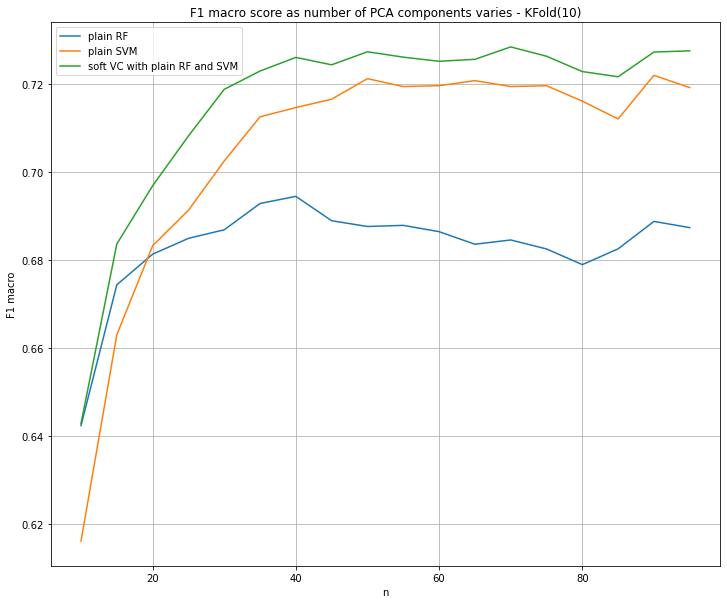

In [75]:
plt.figure(figsize=(12,10))
plt.plot(ns, scores_rf, label='plain RF')
plt.plot(ns, scores_svm, label='plain SVM')
plt.plot(ns, scores_vc, label='soft VC with plain RF and SVM')
plt.legend()
plt.grid(True)
plt.xlabel('n')
plt.ylabel('F1 macro')
plt.title('F1 macro score as number of PCA components varies - KFold(10)')
plt.savefig('./figures/PCA_tuning.svg', format='svg')

In [76]:
# function used to save predictions

def save_predictions(preds, eval_temp_df, labels_dict, saving_path = './summer_2022_project/', title=''):
    
    final_list = []    
    
    preds_ser = pd.Series(preds)
    
    for id, label in zip(eval_temp_df.index, preds_ser.map({v:k for k,v in labels_dict.items()})):
        final_list.append((f'{id}.wav', label))
    
    df_f = pd.DataFrame(final_list, columns=['Id', 'Predicted'])
    
    df_f.to_csv(path_or_buf=saving_path+f'/results_new/{title}', header=True, index=False)

## Best Random Forest

In [77]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_rf)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(norm_X, y_res, test_size=.2, random_state=42, stratify=y_res)

In [78]:
# RF tuning

rf_clfs = []
param_grid_rf = {
    'n_estimators' : [150,300],
    'criterion': ['gini', 'entropy'],# 'log_loss'],
    'max_depth': [20,30,None],
    #'max_features': ['sqrt', 'log2']
}

for configuration in tqdm(ParameterGrid(param_grid_rf)):
    
    kf = KFold(10)
    
    scores_rf = []
    
    counts = []
    for train_indices, valid_indices in tqdm(kf.split(X_train_valid)):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid.iloc[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid.iloc[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 

        rf = RandomForestClassifier(random_state=42, **configuration)
        rf.fit(X_train, y_train)
        rf_score = f1_score(y_valid, rf.predict(X_valid), average='macro')
        # print('RF:',rf_score)
        scores_rf.append(rf_score)
        
    rf_avg = np.average(scores_rf, weights=counts)
    rf_clfs.append((rf, rf_avg))
    print(rf_avg, configuration)
    
best_rf_index = np.argmax([clf[1] for clf in rf_clfs])
best_config = list(ParameterGrid(param_grid_rf))[best_rf_index]
#clf = rf_clfs[best_rf_index][0]

clf = RandomForestClassifier(random_state=42, **best_config)

print('Fitting...')
clf.fit(norm_X, y_res)

# transformations on eval dataset
pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='00_RF_kfold.csv')


10it [01:01,  6.15s/it]00:00<?, ?it/s]
  8%|▊         | 1/12 [01:01<11:17, 61.55s/it]

0.6965932016280696 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150}


10it [01:59, 11.97s/it]
 17%|█▋        | 2/12 [03:01<15:57, 95.75s/it]

0.7002488912422811 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}


10it [01:01,  6.12s/it]
 25%|██▌       | 3/12 [04:02<11:59, 79.96s/it]

0.6957398113704122 {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 150}


10it [02:02, 12.24s/it]
 33%|███▎      | 4/12 [06:04<12:53, 96.72s/it]

0.703198017177483 {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 300}


10it [01:01,  6.11s/it]
 42%|████▏     | 5/12 [07:05<09:47, 83.87s/it]

0.696495949039608 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}


10it [02:01, 12.18s/it]
 50%|█████     | 6/12 [09:07<09:40, 96.75s/it]

0.7038195841534045 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}


10it [01:55, 11.52s/it]
 58%|█████▊    | 7/12 [11:02<08:33, 102.78s/it]

0.6937107302025696 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}


10it [03:48, 22.87s/it]
 67%|██████▋   | 8/12 [14:51<09:31, 142.87s/it]

0.6984236584096 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}


10it [01:54, 11.49s/it]
 75%|███████▌  | 9/12 [16:46<06:42, 134.14s/it]

0.6958873818254191 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 150}


10it [03:48, 22.81s/it]
 83%|████████▎ | 10/12 [20:34<05:26, 163.14s/it]

0.6985186240784244 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 300}


10it [01:54, 11.44s/it]
 92%|█████████▏| 11/12 [22:28<02:28, 148.22s/it]

0.6958834773981847 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}


10it [03:48, 22.88s/it]
100%|██████████| 12/12 [26:17<00:00, 131.48s/it]


0.6989669009598413 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
Fitting...
Predicting...


In [79]:
best_config

{'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}

In [73]:
np.argmax([i[1] for i in rf_clfs])
rf_clfs[np.argmax([i[1] for i in rf_clfs])]

(RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=42),
 0.6302336883803841)

Result on leaderboard of best RF with cross val: 0.668

## Best SVM

In [81]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_svm)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(norm_X, y_res, test_size=.2, random_state=42, stratify=y_res)

In [82]:
# SVM tuning

svm_clfs = []

param_grid_svm = {'C':[1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 500],
              #'decision_function_shape':['ovo', 'ovr']}
              #'kernel': ['rbf', 'poly']
              }
              

for configuration in tqdm(ParameterGrid(param_grid_svm)):
    
    kf = KFold(10)
    
    scores_svm = []
    
    counts = []
    for train_indices, valid_indices in tqdm(kf.split(X_train_valid)):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid.iloc[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid.iloc[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 

        svm = SVC(random_state=42, **configuration).fit(X_train, y_train)
        
        svm_score = f1_score(y_valid, svm.predict(X_valid), average='macro')
       
        scores_svm.append(svm_score)
        
    svm_avg = np.average(scores_svm, weights=counts)
    svm_clfs.append((svm, svm_avg))
    print(svm_avg, configuration)

best_svm_index = np.argmax([clf[1] for clf in svm_clfs])
best_config_svm = list(ParameterGrid(param_grid_svm))[best_svm_index]
clf = SVC(random_state=42, **best_config_svm)

print('Fitting...')
clf.fit(norm_X, y_res)

# transformations on eval dataset
pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='01_SVM_kfold.csv')

10it [00:46,  4.62s/it]00:00<?, ?it/s]
  9%|▉         | 1/11 [00:46<07:42, 46.21s/it]

0.7220574386871977 {'C': 1}


10it [00:50,  5.00s/it]
 18%|█▊        | 2/11 [01:36<07:16, 48.45s/it]

0.7425336565409543 {'C': 3}


10it [00:53,  5.35s/it]
 27%|██▋       | 3/11 [02:29<06:46, 50.78s/it]

0.7409811831421881 {'C': 5}


10it [00:57,  5.77s/it]
 36%|███▋      | 4/11 [03:27<06:14, 53.49s/it]

0.7382356661070489 {'C': 7}


10it [00:59,  5.95s/it]
 45%|████▌     | 5/11 [04:26<05:33, 55.66s/it]

0.7346696603260298 {'C': 10}


10it [01:03,  6.31s/it]
 55%|█████▍    | 6/11 [05:30<04:51, 58.20s/it]

0.7325660967884051 {'C': 15}


10it [01:03,  6.39s/it]
 64%|██████▎   | 7/11 [06:33<04:00, 60.05s/it]

0.7308512342631913 {'C': 20}


10it [01:07,  6.73s/it]
 73%|███████▎  | 8/11 [07:41<03:07, 62.37s/it]

0.7300603877483437 {'C': 30}


10it [01:10,  7.09s/it]
 82%|████████▏ | 9/11 [08:52<02:10, 65.03s/it]

0.7305008885473424 {'C': 50}


10it [01:04,  6.46s/it]
 91%|█████████ | 10/11 [09:56<01:04, 64.90s/it]

0.7305008885473424 {'C': 100}


10it [01:05,  6.50s/it]
100%|██████████| 11/11 [11:01<00:00, 60.16s/it]


0.7305008885473424 {'C': 500}
Fitting...
Predicting...


Best SVM with KFOLD: 0.707

## Best Voting Classifier

In [91]:
scores_vc[np.argmax(scores_vc)], ns[np.argmax(scores_vc)]

(0.7285213936382442, 70)

In [92]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_vc)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(norm_X, y_res, test_size=.2, random_state=42, stratify=y_res)

In [93]:
# SVM tuning

svm_clfs = []

param_grid_svm = {'C':[1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 500],
              #'decision_function_shape':['ovo', 'ovr']}
              #'kernel': ['rbf', 'poly']
              }
              

for configuration in tqdm(ParameterGrid(param_grid_svm)):
    
    kf = KFold(10)
    
    scores_svm = []
    
    counts = []
    for train_indices, valid_indices in tqdm(kf.split(X_train_valid)):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid.iloc[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid.iloc[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 

        svm = SVC(random_state=42, **configuration).fit(X_train, y_train)
        
        svm_score = f1_score(y_valid, svm.predict(X_valid), average='macro')
       
        scores_svm.append(svm_score)
        
    svm_avg = np.average(scores_svm, weights=counts)
    svm_clfs.append((svm, svm_avg))
    print(svm_avg, configuration)

best_svm_index = np.argmax([clf[1] for clf in svm_clfs])
best_config_svm = list(ParameterGrid(param_grid_svm))[best_svm_index]
best_svm = SVC(random_state=42, probability=True, **best_config_svm)


10it [00:43,  4.34s/it]00:00<?, ?it/s]
  9%|▉         | 1/11 [00:43<07:14, 43.41s/it]

0.7195117408614888 {'C': 1}


10it [00:46,  4.61s/it]
 18%|█▊        | 2/11 [01:29<06:44, 44.99s/it]

0.7407919040737131 {'C': 3}


10it [00:44,  4.43s/it]
 27%|██▋       | 3/11 [02:13<05:57, 44.68s/it]

0.7417474473244662 {'C': 5}


10it [00:46,  4.69s/it]
 36%|███▋      | 4/11 [03:00<05:18, 45.55s/it]

0.7401310655584056 {'C': 7}


10it [00:48,  4.85s/it]
 45%|████▌     | 5/11 [03:49<04:39, 46.61s/it]

0.7393742337777675 {'C': 10}


10it [00:50,  5.06s/it]
 55%|█████▍    | 6/11 [04:39<03:59, 47.98s/it]

0.7345155308291498 {'C': 15}


10it [00:51,  5.15s/it]
 64%|██████▎   | 7/11 [05:31<03:16, 49.14s/it]

0.7326823972110955 {'C': 20}


10it [00:54,  5.41s/it]
 73%|███████▎  | 8/11 [06:25<02:32, 50.72s/it]

0.7303758888093663 {'C': 30}


10it [00:55,  5.56s/it]
 82%|████████▏ | 9/11 [07:21<01:44, 52.26s/it]

0.7297491803072932 {'C': 50}


10it [00:53,  5.38s/it]
 91%|█████████ | 10/11 [08:14<00:52, 52.73s/it]

0.7296364953454246 {'C': 100}


10it [00:53,  5.31s/it]
100%|██████████| 11/11 [09:07<00:00, 49.82s/it]

0.7296364953454246 {'C': 500}


In [94]:
# RF tuning

rf_clfs = []
param_grid_rf = {
    'n_estimators' : [150,300],
    'criterion': ['gini', 'entropy'],# 'log_loss'],
    'max_depth': [20,30,None],
    #'max_features': ['sqrt', 'log2']
}

for configuration in tqdm(ParameterGrid(param_grid_rf)):
    
    kf = KFold(10)
    
    scores_rf = []
    
    counts = []
    for train_indices, valid_indices in tqdm(kf.split(X_train_valid)):
        X_train = X_train_valid[train_indices]
        y_train = y_train_valid.iloc[train_indices]
        X_valid = X_train_valid[valid_indices]
        y_valid = y_train_valid.iloc[valid_indices]
        
        # keep track of the number of elements in each split
        counts.append(len(train_indices)) 

        rf = RandomForestClassifier(random_state=42, **configuration)
        rf.fit(X_train, y_train)
        rf_score = f1_score(y_valid, rf.predict(X_valid), average='macro')
        # print('RF:',rf_score)
        scores_rf.append(rf_score)
        
    rf_avg = np.average(scores_rf, weights=counts)
    rf_clfs.append((rf, rf_avg))
    print(rf_avg, configuration)
    
best_rf_index = np.argmax([clf[1] for clf in rf_clfs])
best_config = list(ParameterGrid(param_grid_rf))[best_rf_index]

best_rf = RandomForestClassifier(random_state=42, **best_config)


10it [01:15,  7.52s/it]00:00<?, ?it/s]
  8%|▊         | 1/12 [01:15<13:46, 75.18s/it]

0.6882253670848663 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150}


10it [02:27, 14.77s/it]
 17%|█▋        | 2/12 [03:42<19:38, 117.84s/it]

0.6922511358804815 {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}


10it [01:14,  7.43s/it]
 25%|██▌       | 3/12 [04:57<14:41, 97.97s/it] 

0.690026666393904 {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 150}


10it [02:28, 14.86s/it]
 33%|███▎      | 4/12 [07:25<15:43, 117.95s/it]

0.6917496437105686 {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 300}


10it [01:14,  7.42s/it]
 42%|████▏     | 5/12 [08:39<11:55, 102.16s/it]

0.6881237196171754 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 150}


10it [02:27, 14.76s/it]
 50%|█████     | 6/12 [11:07<11:45, 117.60s/it]

0.6913263088484448 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300}


10it [02:26, 14.61s/it]
 58%|█████▊    | 7/12 [13:33<10:34, 126.91s/it]

0.6890320211986581 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}


10it [04:45, 28.59s/it]
 67%|██████▋   | 8/12 [18:19<11:50, 177.52s/it]

0.6961052723300992 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}


10it [02:25, 14.55s/it]
 75%|███████▌  | 9/12 [20:44<08:22, 167.50s/it]

0.6866895281646347 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 150}


10it [04:54, 29.42s/it]
 83%|████████▎ | 10/12 [25:39<06:53, 206.63s/it]

0.6947912720543155 {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 300}


10it [02:26, 14.69s/it]
 92%|█████████▏| 11/12 [28:06<03:08, 188.35s/it]

0.6870996539333002 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}


10it [05:02, 30.23s/it]
100%|██████████| 12/12 [33:08<00:00, 165.70s/it]

0.6948530943368324 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}


In [95]:
best_svm, best_rf

(SVC(C=5, probability=True, random_state=42),
 RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                        random_state=42))

In [97]:
# Voting classifier with best svm and best rf

#rf = RandomForestClassifier(criterion='entropy', max_depth=20, 
#                            n_estimators=300, random_state=42)

#svc = SVC(C=5, random_state=42, probability=True)

clf = VotingClassifier([('svm',best_svm), ('rf', best_rf)], voting='soft')

print('Fitting...')
clf.fit(norm_X, y_res)

pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='00_VC_kfold_soft.csv')

Fitting...
Predicting...


Best VC:
- 0.701 (soft)
- 0.696 (hard)

K fold results are better

-------------
# Results without K fold

In [121]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

np.random.seed(0) 


smote = SMOTE(random_state=42)

X, y = temp_df[temp_df.columns[:-1]], temp_df[temp_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

In [122]:
from sklearn.model_selection import ParameterGrid

  0%|          | 0/18 [00:00<?, ?it/s]

10
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6561094748530923
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.6216420021704268
Fitting voting classifier...
Predicting voting classifier...


  6%|▌         | 1/18 [00:42<12:09, 42.92s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.6514234892446426
15
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6757055236513175
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.6659733899515548
Fitting voting classifier...
Predicting voting classifier...


 11%|█         | 2/18 [01:25<11:26, 42.91s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.6801681884273082
20
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6892774291110927
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.6839132927403416
Fitting voting classifier...
Predicting voting classifier...


 17%|█▋        | 3/18 [02:12<11:08, 44.54s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7001735242677161
25
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6957755847009796
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7013226330525085
Fitting voting classifier...
Predicting voting classifier...


 22%|██▏       | 4/18 [03:06<11:14, 48.21s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7186176943297454
30
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6975220292450679
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7108181972344809
Fitting voting classifier...
Predicting voting classifier...


 28%|██▊       | 5/18 [04:04<11:14, 51.91s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.72337239771231
35
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.7014307526496231
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7148571615797081
Fitting voting classifier...
Predicting voting classifier...


 33%|███▎      | 6/18 [05:06<11:02, 55.19s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7260968328969541
40
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6937687483431585
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7237763098930294
Fitting voting classifier...
Predicting voting classifier...


 39%|███▉      | 7/18 [06:10<10:40, 58.23s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7310367874520887
45
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6938892002557705
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7222045035322976
Fitting voting classifier...
Predicting voting classifier...


 44%|████▍     | 8/18 [07:27<10:41, 64.11s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7370733151525928
50
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6952892492753618
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7273486184458801
Fitting voting classifier...
Predicting voting classifier...


 50%|█████     | 9/18 [08:36<09:51, 65.68s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7369086947363376
55
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.700047047667412
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7331549437288031
Fitting voting classifier...
Predicting voting classifier...


 56%|█████▌    | 10/18 [09:44<08:49, 66.25s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7350052586557403
60
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.7056485883140043
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7317684236392011
Fitting voting classifier...
Predicting voting classifier...


 61%|██████    | 11/18 [11:01<08:08, 69.78s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7377368358581528
65
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6940927930719977
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7307459957134886
Fitting voting classifier...
Predicting voting classifier...


 67%|██████▋   | 12/18 [12:11<06:57, 69.62s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7390683520962879
70
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6968102893447282
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7379546313233607
Fitting voting classifier...
Predicting voting classifier...


 72%|███████▏  | 13/18 [13:23<05:52, 70.49s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7394190014420783
75
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6816397597983449
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7292448024583829
Fitting voting classifier...
Predicting voting classifier...


 78%|███████▊  | 14/18 [14:39<04:48, 72.06s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7348773044202945
80
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.686099564812575
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7310461844916867
Fitting voting classifier...
Predicting voting classifier...


 83%|████████▎ | 15/18 [15:55<03:40, 73.44s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7344075437491611
85
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6938254866711472
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7285414810729555
Fitting voting classifier...
Predicting voting classifier...


 89%|████████▉ | 16/18 [17:19<02:33, 76.51s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7372261362554653
90
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6933900507701015
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7341032831717164
Fitting voting classifier...
Predicting voting classifier...


 94%|█████████▍| 17/18 [18:49<01:20, 80.44s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7377719503931879
95
Fitting RF...
Predicting using RF...
RandomForestClassifier(random_state=42) 0.6907818366356625
Fitting SVC...
Predicting using SVC...
SVC(random_state=42) 0.7302434046084706
Fitting voting classifier...
Predicting voting classifier...


100%|██████████| 18/18 [20:20<00:00, 67.80s/it]

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft') 0.7348864070522595


Text(0.5, 1.0, 'F1 macro score as number of PCA components varies')

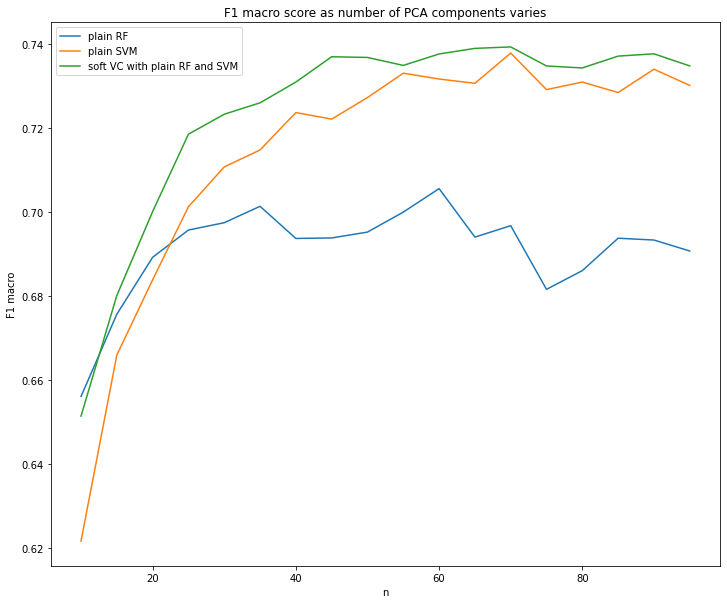

In [123]:
# PCA tuning

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# ----- PCA ----- #
from sklearn.decomposition import PCA

ns = list(range(10, round(len(X.columns)/2),5))
scores_rf = []
scores_svm = [] 
scores_vc = []
for n in tqdm(ns):
    print(n)
    pca = PCA(n_components=n, random_state=42)
    pca_X = pca.fit_transform(X_res)

    # Standardization
    minmax = MinMaxScaler()
    norm_X = minmax.fit_transform(pca_X)

    X_train, X_test, y_train, y_test = train_test_split(norm_X, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    print('Fitting RF...')
    rf = RandomForestClassifier(random_state=42).fit(X_train, y_train) # plain rf
    print('Predicting using RF...')
    preds = rf.predict(X_test)
    
    score = f1_score(y_test, preds, average='macro')
    scores_rf.append(score)
    print(rf, score)


    print('Fitting SVC...')
    svm = SVC(random_state=42).fit(X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    scores_svm.append(svm_score)
    print(svm, svm_score)
    
    print('Fitting voting classifier...')
    svm_vc = SVC(probability=True).fit(X_train, y_train)
    vc = VotingClassifier([('svm', svm_vc), ('rf', rf)], voting='soft' ).fit(X_train, y_train)
    print('Predicting voting classifier...')
    preds = vc.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores_vc.append(score)
    print(vc, score)

plt.figure(figsize=(12,10))
plt.plot(ns, scores_rf, label='plain RF')
plt.plot(ns, scores_svm, label='plain SVM')
plt.plot(ns, scores_vc, label='soft VC with plain RF and SVM')
plt.legend()
plt.xlabel('n')
plt.ylabel('F1 macro')
plt.title('F1 macro score as number of PCA components varies')


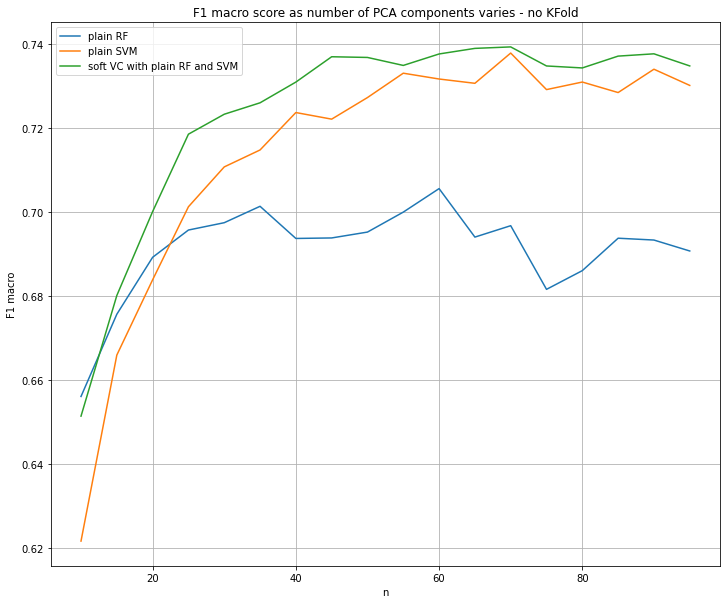

In [124]:
plt.figure(figsize=(12,10))
plt.plot(ns, scores_rf, label='plain RF')
plt.plot(ns, scores_svm, label='plain SVM')
plt.plot(ns, scores_vc, label='soft VC with plain RF and SVM')
plt.legend()
plt.grid(True)
plt.xlabel('n')
plt.ylabel('F1 macro')
plt.title('F1 macro score as number of PCA components varies - no KFold')
plt.savefig('./figures/PCA_tuning_no_kfold_nosilenceremoval.svg', format='svg')

## Best Random Forest

In [125]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_rf)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train, X_test, y_train, y_test = train_test_split(norm_X, y_res, test_size=.2, random_state=42)

In [126]:
# RF tuning

rf_clfs = []
param_grid_rf = {
    'n_estimators' : [150,300],
    'criterion': ['gini', 'entropy'],# 'log_loss'],
    'max_depth': [20,30,None],
    #'max_features': ['sqrt', 'log2']
}

for configuration in tqdm(ParameterGrid(param_grid_rf)):
    print('Fitting RF...')
    rf = RandomForestClassifier(random_state=42, **configuration).fit(X_train, y_train)
    print('Predicting using RF...')
    rf_preds = rf.predict(X_test)
    rf_score = f1_score(y_test, rf_preds, average='macro')
    print(rf, rf_score)
    rf_clfs.append((rf, rf_score))
    
    
best_rf_index = np.argmax([clf[1] for clf in rf_clfs])

clf = rf_clfs[best_rf_index][0]

print('Fitting...')
clf.fit(norm_X, y_res)

# transformations on eval dataset
pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='00_RF_no_KFold.csv')


  0%|          | 0/12 [00:00<?, ?it/s]

Fitting RF...


  8%|▊         | 1/12 [00:07<01:26,  7.86s/it]

Predicting using RF...
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42) 0.6932808756568241
Fitting RF...


 17%|█▋        | 2/12 [00:23<02:02, 12.21s/it]

Predicting using RF...
RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42) 0.6998069033647886
Fitting RF...


 25%|██▌       | 3/12 [00:31<01:32, 10.30s/it]

Predicting using RF...
RandomForestClassifier(max_depth=30, n_estimators=150, random_state=42) 0.6992726679422436
Fitting RF...


 33%|███▎      | 4/12 [00:46<01:37, 12.23s/it]

Predicting using RF...
RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42) 0.7056076540248822
Fitting RF...


 42%|████▏     | 5/12 [00:53<01:13, 10.56s/it]

Predicting using RF...
RandomForestClassifier(n_estimators=150, random_state=42) 0.7001302988000511
Fitting RF...


 50%|█████     | 6/12 [01:09<01:12, 12.16s/it]

Predicting using RF...
RandomForestClassifier(n_estimators=300, random_state=42) 0.7035298270591598
Fitting RF...


 58%|█████▊    | 7/12 [01:23<01:04, 12.89s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       random_state=42) 0.6963309536814106
Fitting RF...


 67%|██████▋   | 8/12 [01:52<01:12, 18.03s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                       random_state=42) 0.7002885979461994
Fitting RF...


 75%|███████▌  | 9/12 [02:06<00:50, 16.70s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=150,
                       random_state=42) 0.6979862605276372
Fitting RF...


 83%|████████▎ | 10/12 [02:33<00:39, 20.00s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=300,
                       random_state=42) 0.7046757455385751
Fitting RF...


 92%|█████████▏| 11/12 [02:48<00:18, 18.34s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=42) 0.6983756688665945
Fitting RF...


100%|██████████| 12/12 [03:17<00:00, 16.42s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=42) 0.7042218497359126
Fitting...


Predicting...


Result on leaderboard of best RF: 0.666

In [127]:
rf_clfs

[(RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42),
  0.6932808756568241),
 (RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42),
  0.6998069033647886),
 (RandomForestClassifier(max_depth=30, n_estimators=150, random_state=42),
  0.6992726679422436),
 (RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42),
  0.7056076540248822),
 (RandomForestClassifier(n_estimators=150, random_state=42),
  0.7001302988000511),
 (RandomForestClassifier(n_estimators=300, random_state=42),
  0.7035298270591598),
 (RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                         random_state=42),
  0.6963309536814106),
 (RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                         random_state=42),
  0.7002885979461994),
 (RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=150,
                         random_state=42),
  0.6979862605276372),
 (Random

## Best SVM

In [128]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_svm)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train, X_test, y_train, y_test = train_test_split(norm_X, y_res, test_size=.2, random_state=42)

In [129]:
# SVM tuning

def run_svm_grid_search(param_grid:dict, svm_X_train, svm_X_test, y_train, y_test):
    clfs = []
    for configuration in tqdm(ParameterGrid(param_grid)):
        print('Fitting SVC...')
        svm = SVC(random_state=42, **configuration).fit(svm_X_train, y_train)
        print('Predicting using SVC...')
        svm_preds = svm.predict(svm_X_test)
        svm_score = f1_score(y_test, svm_preds, average='macro')
        print(svm, svm_score)
        clfs.append((svm, svm_score))
    return clfs

param_grid = {'C':[1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 500],
              #'decision_function_shape':['ovo', 'ovr']}
              #'kernel': ['rbf', 'poly']
              }
              

svm_clfs = run_svm_grid_search(param_grid, X_train, X_test, y_train, y_test)

best_svm_index = np.argmax([clf[1] for clf in svm_clfs])

clf = svm_clfs[best_svm_index][0]

print('Fitting...')
clf.fit(norm_X, y_res)

# transformations on eval dataset
pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='01_SVM_no_KFold.csv')

  0%|          | 0/11 [00:00<?, ?it/s]

Fitting SVC...
Predicting using SVC...


  9%|▉         | 1/11 [00:06<01:06,  6.68s/it]

SVC(C=1, random_state=42) 0.7379546313233607
Fitting SVC...
Predicting using SVC...


 18%|█▊        | 2/11 [00:13<01:01,  6.84s/it]

SVC(C=3, random_state=42) 0.7508095359604171
Fitting SVC...
Predicting using SVC...


 27%|██▋       | 3/11 [00:21<00:57,  7.13s/it]

SVC(C=5, random_state=42) 0.7560069542760836
Fitting SVC...
Predicting using SVC...


 36%|███▋      | 4/11 [00:28<00:50,  7.16s/it]

SVC(C=7, random_state=42) 0.7486383393712835
Fitting SVC...
Predicting using SVC...


 45%|████▌     | 5/11 [00:36<00:44,  7.37s/it]

SVC(C=10, random_state=42) 0.7483506313400888
Fitting SVC...
Predicting using SVC...


 55%|█████▍    | 6/11 [00:43<00:37,  7.51s/it]

SVC(C=15, random_state=42) 0.7450009473252395
Fitting SVC...
Predicting using SVC...


 64%|██████▎   | 7/11 [00:51<00:30,  7.58s/it]

SVC(C=20, random_state=42) 0.7416487826445515
Fitting SVC...
Predicting using SVC...


 73%|███████▎  | 8/11 [00:59<00:22,  7.66s/it]

SVC(C=30, random_state=42) 0.7408794261901399
Fitting SVC...
Predicting using SVC...


 82%|████████▏ | 9/11 [01:07<00:15,  7.71s/it]

SVC(C=50, random_state=42) 0.7387556027388721
Fitting SVC...
Predicting using SVC...


 91%|█████████ | 10/11 [01:15<00:07,  7.78s/it]

SVC(C=100, random_state=42) 0.738791071111856
Fitting SVC...
Predicting using SVC...


100%|██████████| 11/11 [01:23<00:00,  7.56s/it]

SVC(C=500, random_state=42) 0.738791071111856
Fitting...


Predicting...


Best SVM: .695

In [131]:
svm_clfs

[(SVC(C=1, random_state=42), 0.7379546313233607),
 (SVC(C=3, random_state=42), 0.7508095359604171),
 (SVC(C=5, random_state=42), 0.7560069542760836),
 (SVC(C=7, random_state=42), 0.7486383393712835),
 (SVC(C=10, random_state=42), 0.7483506313400888),
 (SVC(C=15, random_state=42), 0.7450009473252395),
 (SVC(C=20, random_state=42), 0.7416487826445515),
 (SVC(C=30, random_state=42), 0.7408794261901399),
 (SVC(C=50, random_state=42), 0.7387556027388721),
 (SVC(C=100, random_state=42), 0.738791071111856),
 (SVC(C=500, random_state=42), 0.738791071111856)]

## Best Voting Classifier

In [110]:
# select best pca for voting classifier
pca_n = ns[np.argmax(scores_vc)]
pca = PCA(n_components=pca_n, random_state=42)
pca_X = pca.fit_transform(X_res)

# Standardization
minmax = MinMaxScaler()
norm_X = minmax.fit_transform(pca_X)

X_train, X_test, y_train, y_test = train_test_split(norm_X, y_res, test_size=.2, random_state=42)

In [111]:
# SVM tuning

param_grid = {'C':[1, 3, 5, 7, 10, 15, 20, 30, 50, 100, 500],
              #'decision_function_shape':['ovo', 'ovr']}
              #'kernel': ['rbf', 'poly']
              }
              
svm_clfs = run_svm_grid_search(param_grid, X_train, X_test, y_train, y_test)

best_svm_index = np.argmax([clf[1] for clf in svm_clfs])
best_svm = svm_clfs[best_svm_index][0]
svm_clfs[best_svm_index]

  0%|          | 0/11 [00:00<?, ?it/s]

Fitting SVC...
Predicting using SVC...


  9%|▉         | 1/11 [00:07<01:10,  7.00s/it]

SVC(C=1, random_state=42) 0.7379546313233607
Fitting SVC...
Predicting using SVC...


 18%|█▊        | 2/11 [00:14<01:04,  7.21s/it]

SVC(C=3, random_state=42) 0.7508095359604171
Fitting SVC...
Predicting using SVC...


 27%|██▋       | 3/11 [00:21<00:57,  7.20s/it]

SVC(C=5, random_state=42) 0.7560069542760836
Fitting SVC...
Predicting using SVC...


 36%|███▋      | 4/11 [00:29<00:51,  7.38s/it]

SVC(C=7, random_state=42) 0.7486383393712835
Fitting SVC...
Predicting using SVC...


 45%|████▌     | 5/11 [00:36<00:45,  7.53s/it]

SVC(C=10, random_state=42) 0.7483506313400888
Fitting SVC...
Predicting using SVC...


 55%|█████▍    | 6/11 [00:44<00:38,  7.66s/it]

SVC(C=15, random_state=42) 0.7450009473252395
Fitting SVC...
Predicting using SVC...


 64%|██████▎   | 7/11 [00:52<00:30,  7.67s/it]

SVC(C=20, random_state=42) 0.7416487826445515
Fitting SVC...
Predicting using SVC...


 73%|███████▎  | 8/11 [01:00<00:23,  7.82s/it]

SVC(C=30, random_state=42) 0.7408794261901399
Fitting SVC...
Predicting using SVC...


 82%|████████▏ | 9/11 [01:09<00:15,  7.99s/it]

SVC(C=50, random_state=42) 0.7387556027388721
Fitting SVC...
Predicting using SVC...


 91%|█████████ | 10/11 [01:17<00:08,  8.21s/it]

SVC(C=100, random_state=42) 0.738791071111856
Fitting SVC...
Predicting using SVC...


100%|██████████| 11/11 [01:26<00:00,  7.83s/it]

SVC(C=500, random_state=42) 0.738791071111856


(SVC(C=5, random_state=42), 0.7560069542760836)

In [112]:
# RF tuning

rf_clfs = []
param_grid_rf = {
    'n_estimators' : [150,300],
    'criterion': ['gini', 'entropy'],# 'log_loss'],
    'max_depth': [20,30,None],
    #'max_features': ['sqrt', 'log2']
}

for configuration in tqdm(ParameterGrid(param_grid_rf)):
    print('Fitting RF...')
    rf = RandomForestClassifier(random_state=42, **configuration).fit(X_train, y_train)
    print('Predicting using RF...')
    rf_preds = rf.predict(X_test)
    rf_score = f1_score(y_test, rf_preds, average='macro')
    print(rf, rf_score)
    rf_clfs.append((rf, rf_score))
    
    
best_rf_index = np.argmax([clf[1] for clf in rf_clfs])
best_rf = rf_clfs[best_rf_index][0]
rf_clfs[best_rf_index]

  0%|          | 0/12 [00:00<?, ?it/s]

Fitting RF...


  8%|▊         | 1/12 [00:08<01:33,  8.49s/it]

Predicting using RF...
RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42) 0.6897934302417937
Fitting RF...


 17%|█▋        | 2/12 [00:26<02:22, 14.27s/it]

Predicting using RF...
RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42) 0.6921986086637657
Fitting RF...


 25%|██▌       | 3/12 [00:36<01:49, 12.22s/it]

Predicting using RF...
RandomForestClassifier(max_depth=30, n_estimators=150, random_state=42) 0.7075914545759133
Fitting RF...


 33%|███▎      | 4/12 [00:56<02:01, 15.13s/it]

Predicting using RF...
RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42) 0.7074990942704436
Fitting RF...


 42%|████▏     | 5/12 [01:06<01:32, 13.26s/it]

Predicting using RF...
RandomForestClassifier(n_estimators=150, random_state=42) 0.7057045643696389
Fitting RF...


 50%|█████     | 6/12 [01:24<01:30, 15.06s/it]

Predicting using RF...
RandomForestClassifier(n_estimators=300, random_state=42) 0.706326382793672
Fitting RF...


 58%|█████▊    | 7/12 [01:42<01:19, 15.85s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150,
                       random_state=42) 0.6986114523819673
Fitting RF...


 67%|██████▋   | 8/12 [02:16<01:27, 21.76s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300,
                       random_state=42) 0.698375467369944
Fitting RF...


 75%|███████▌  | 9/12 [02:32<01:00, 20.03s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=150,
                       random_state=42) 0.6903596978080119
Fitting RF...


 83%|████████▎ | 10/12 [03:05<00:47, 23.94s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=300,
                       random_state=42) 0.6996523951368204
Fitting RF...


 92%|█████████▏| 11/12 [03:21<00:21, 21.62s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=42) 0.6920546834426257
Fitting RF...


100%|██████████| 12/12 [03:55<00:00, 19.63s/it]

Predicting using RF...
RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=42) 0.7003939422354638


(RandomForestClassifier(max_depth=30, n_estimators=150, random_state=42),
 0.7075914545759133)

In [116]:
# Voting classifier with best svm and best rf

#rf = RandomForestClassifier(criterion='entropy', max_depth=20, 
#                            n_estimators=300, random_state=42)

rf = RandomForestClassifier(max_depth=30, n_estimators=150, random_state=42)

svc = SVC(C=5, random_state=42, probability=True)

vc = VotingClassifier([('svm',svc), ('rf', rf)], voting='soft')

print('Fitting...')
clf.fit(norm_X, y_res)

pca_eval_df = pca.transform(eval_temp_df)
norm_eval_df = minmax.transform(pca_eval_df)

print('Predicting...')
preds = clf.predict(norm_eval_df)

save_predictions(preds, eval_temp_df, labels_dict, title='02_VC_no_KFold.csv')

Fitting...
Predicting...


Best VC: 0.695